# Import Data

In [15]:
import pandas as pd

data = pd.read_csv("final_merged_300.csv", index_col=0)
data = data.drop(columns=["MP_diff(y)"])
len(data)

5250

# Deal with Null values

In [16]:
print(data.isna().sum())

TCAS_std       0
TCAS_mean      0
TCAS_close     0
TCAS_delta     0
TCAS_corr      0
TCBS_std       0
TCBS_mean      0
TCBS_close     0
TCBS_delta     0
TCBS_corr      0
ALPHA_std      0
ALPHA_mean     0
ALPHA_close    0
ALPHA_delta    0
ALPHA_corr     0
BETA_std       0
BETA_mean      0
BETA_close     0
BETA_delta     0
BETA_corr      0
ZETA_std       0
ZETA_mean      0
ZETA_close     0
ZETA_delta     0
ZETA_corr      0
WMP_std        0
WMP_delta      0
WMP_corr       0
AWS_std        0
AWS_mean       0
AWS_close      0
AWS_delta      0
AWS_corr       0
VOL_std        0
VOL_mean       0
VOL_close      0
VOL_delta      0
VOL_corr       0
GAP_std        0
GAP_mean       0
GAP_close      0
GAP_delta      0
GAP_corr       0
nUoD_std       0
nUoD_mean      0
nUoD_close     0
nUoD_delta     0
nUoD_corr      0
PSTD_std       0
PSTD_mean      0
PSTD_close     0
PSTD_delta     0
PSTD_corr      0
LOWIN_sum      0
HIWIN_sum      0
MP_perc(y)     0
DAY            0
ENDT           0
dtype: int64


In [17]:
for feat in list(data):
    if feat.split("_")[-1] in ["close", "mean"]:
        data = data[~data[feat].isna()] # drop absolute values

data.fillna(0, inplace=True) # fill delta and corr values with 0
len(data)

5250

# EDA

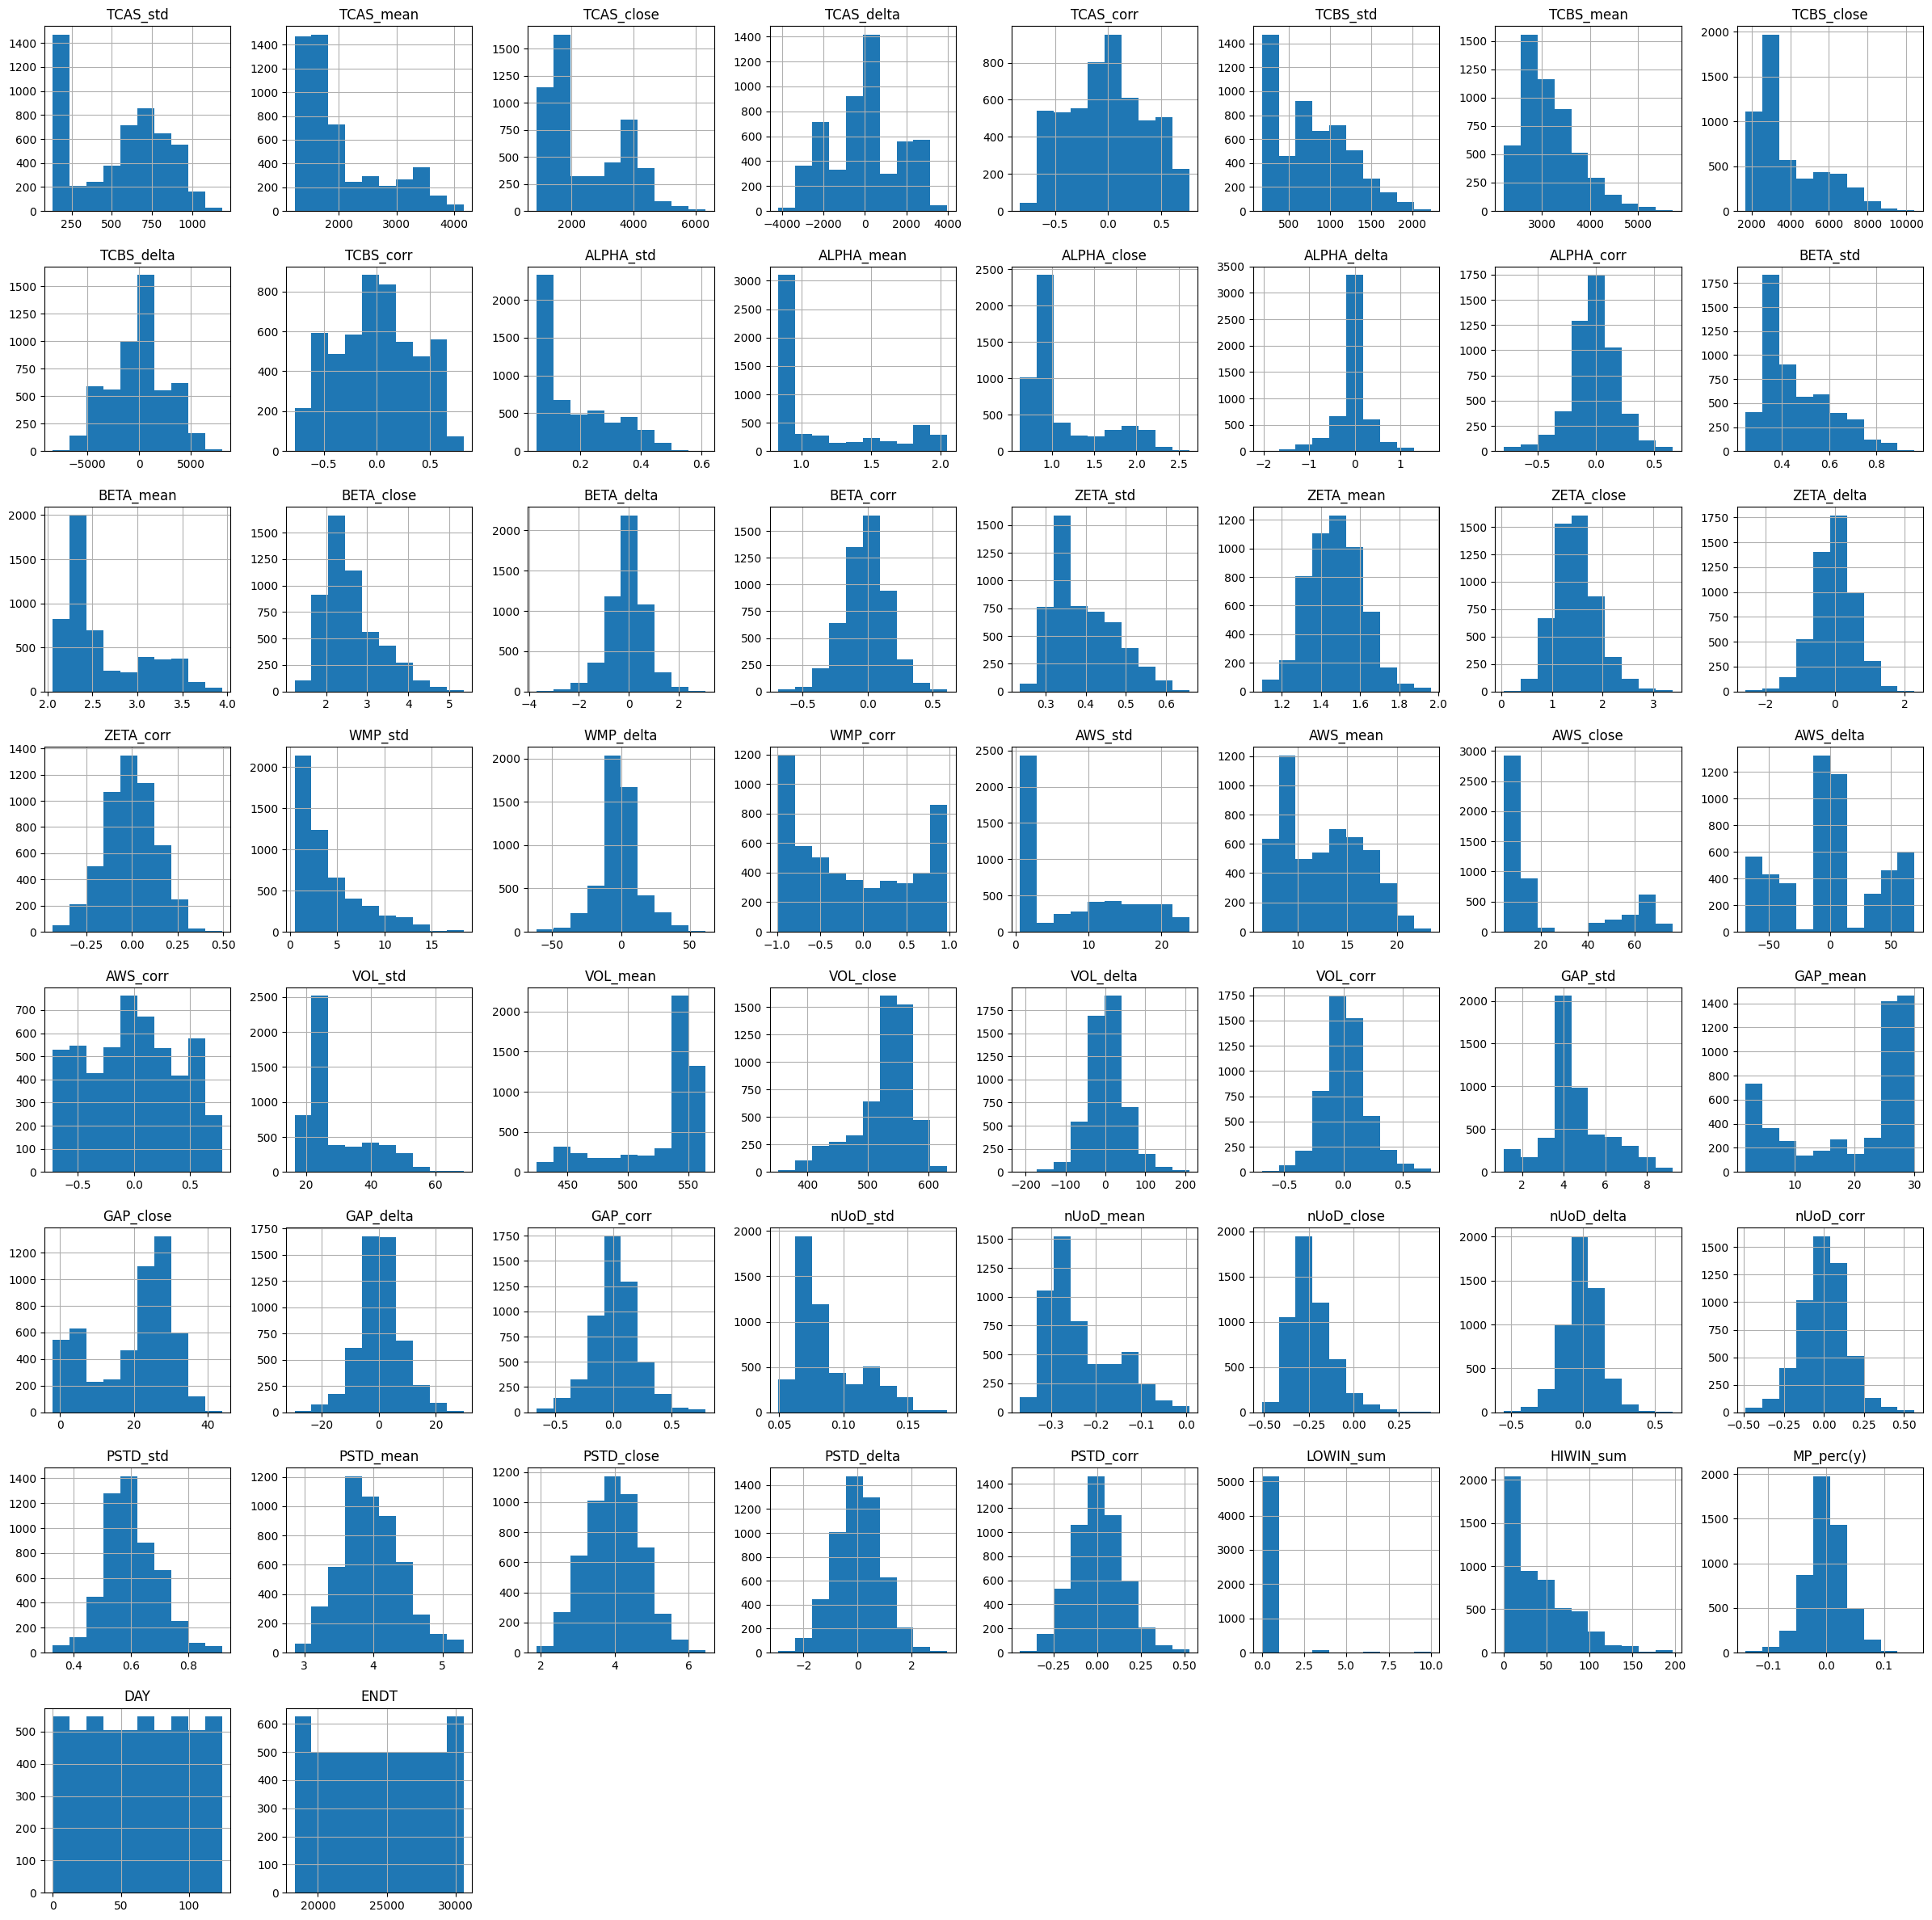

In [18]:
import matplotlib.pyplot as plt
data.hist(figsize=(30,30))
plt.show()

In [19]:
# scale features

x_features = list(data)
x_features.remove("MP_perc(y)")

# scale data between 0 and 1
for col in x_features:
    #data[col] = np.log(data[col] + data[col].min())
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

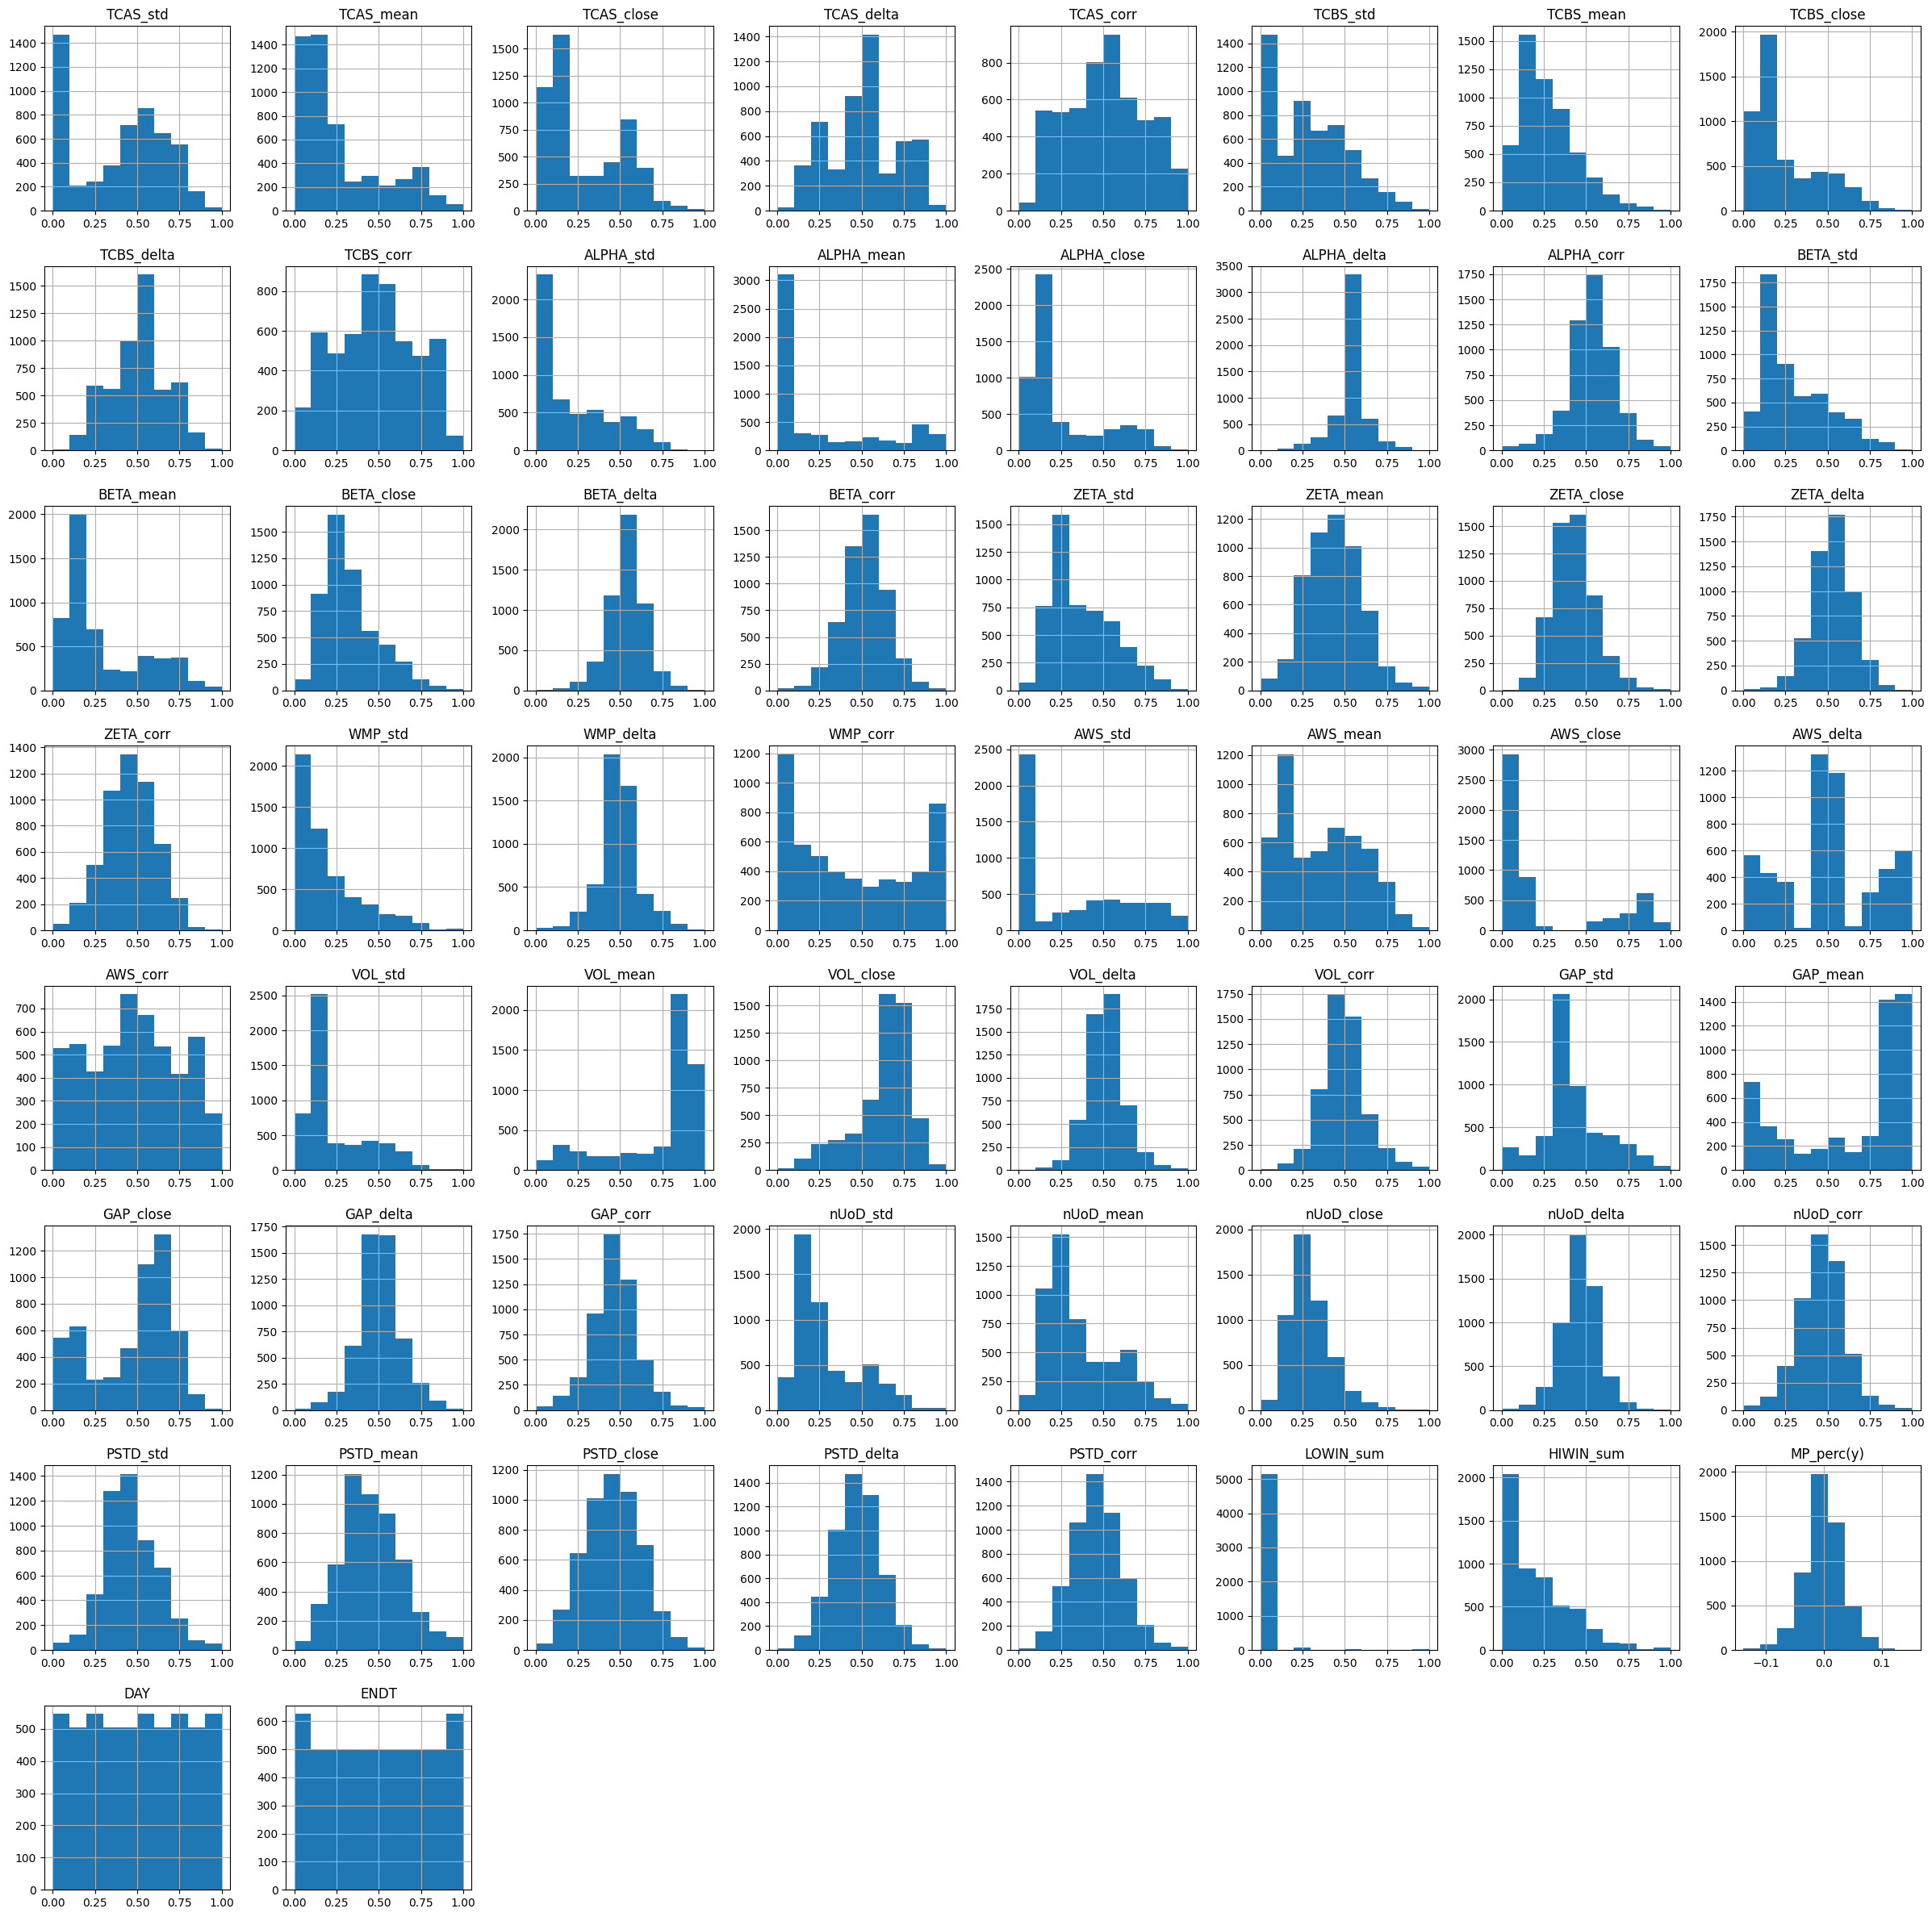

In [20]:
data.hist(figsize=(30,30))
plt.show()

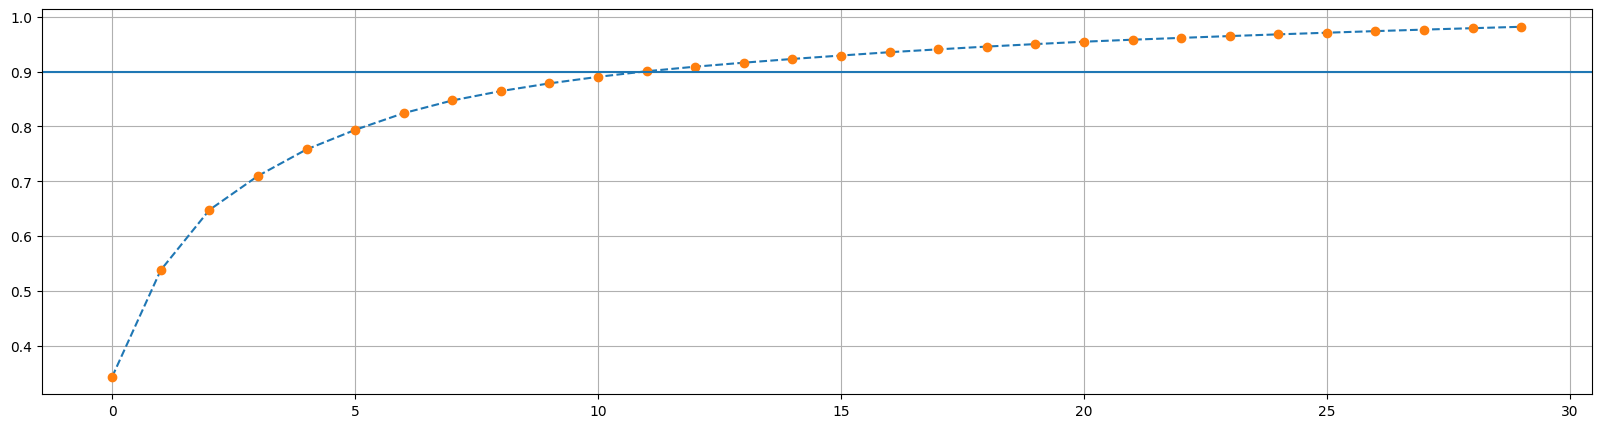

In [21]:
# apply pca
from sklearn.decomposition import PCA
import numpy as np

pca_features = x_features[:]
pca_features.remove("ENDT")
pca_features.remove("DAY")

pca = PCA(n_components=30)
pca_vectors = pca.fit_transform(data[pca_features])

plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle = "--")
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(0.9)
plt.grid()

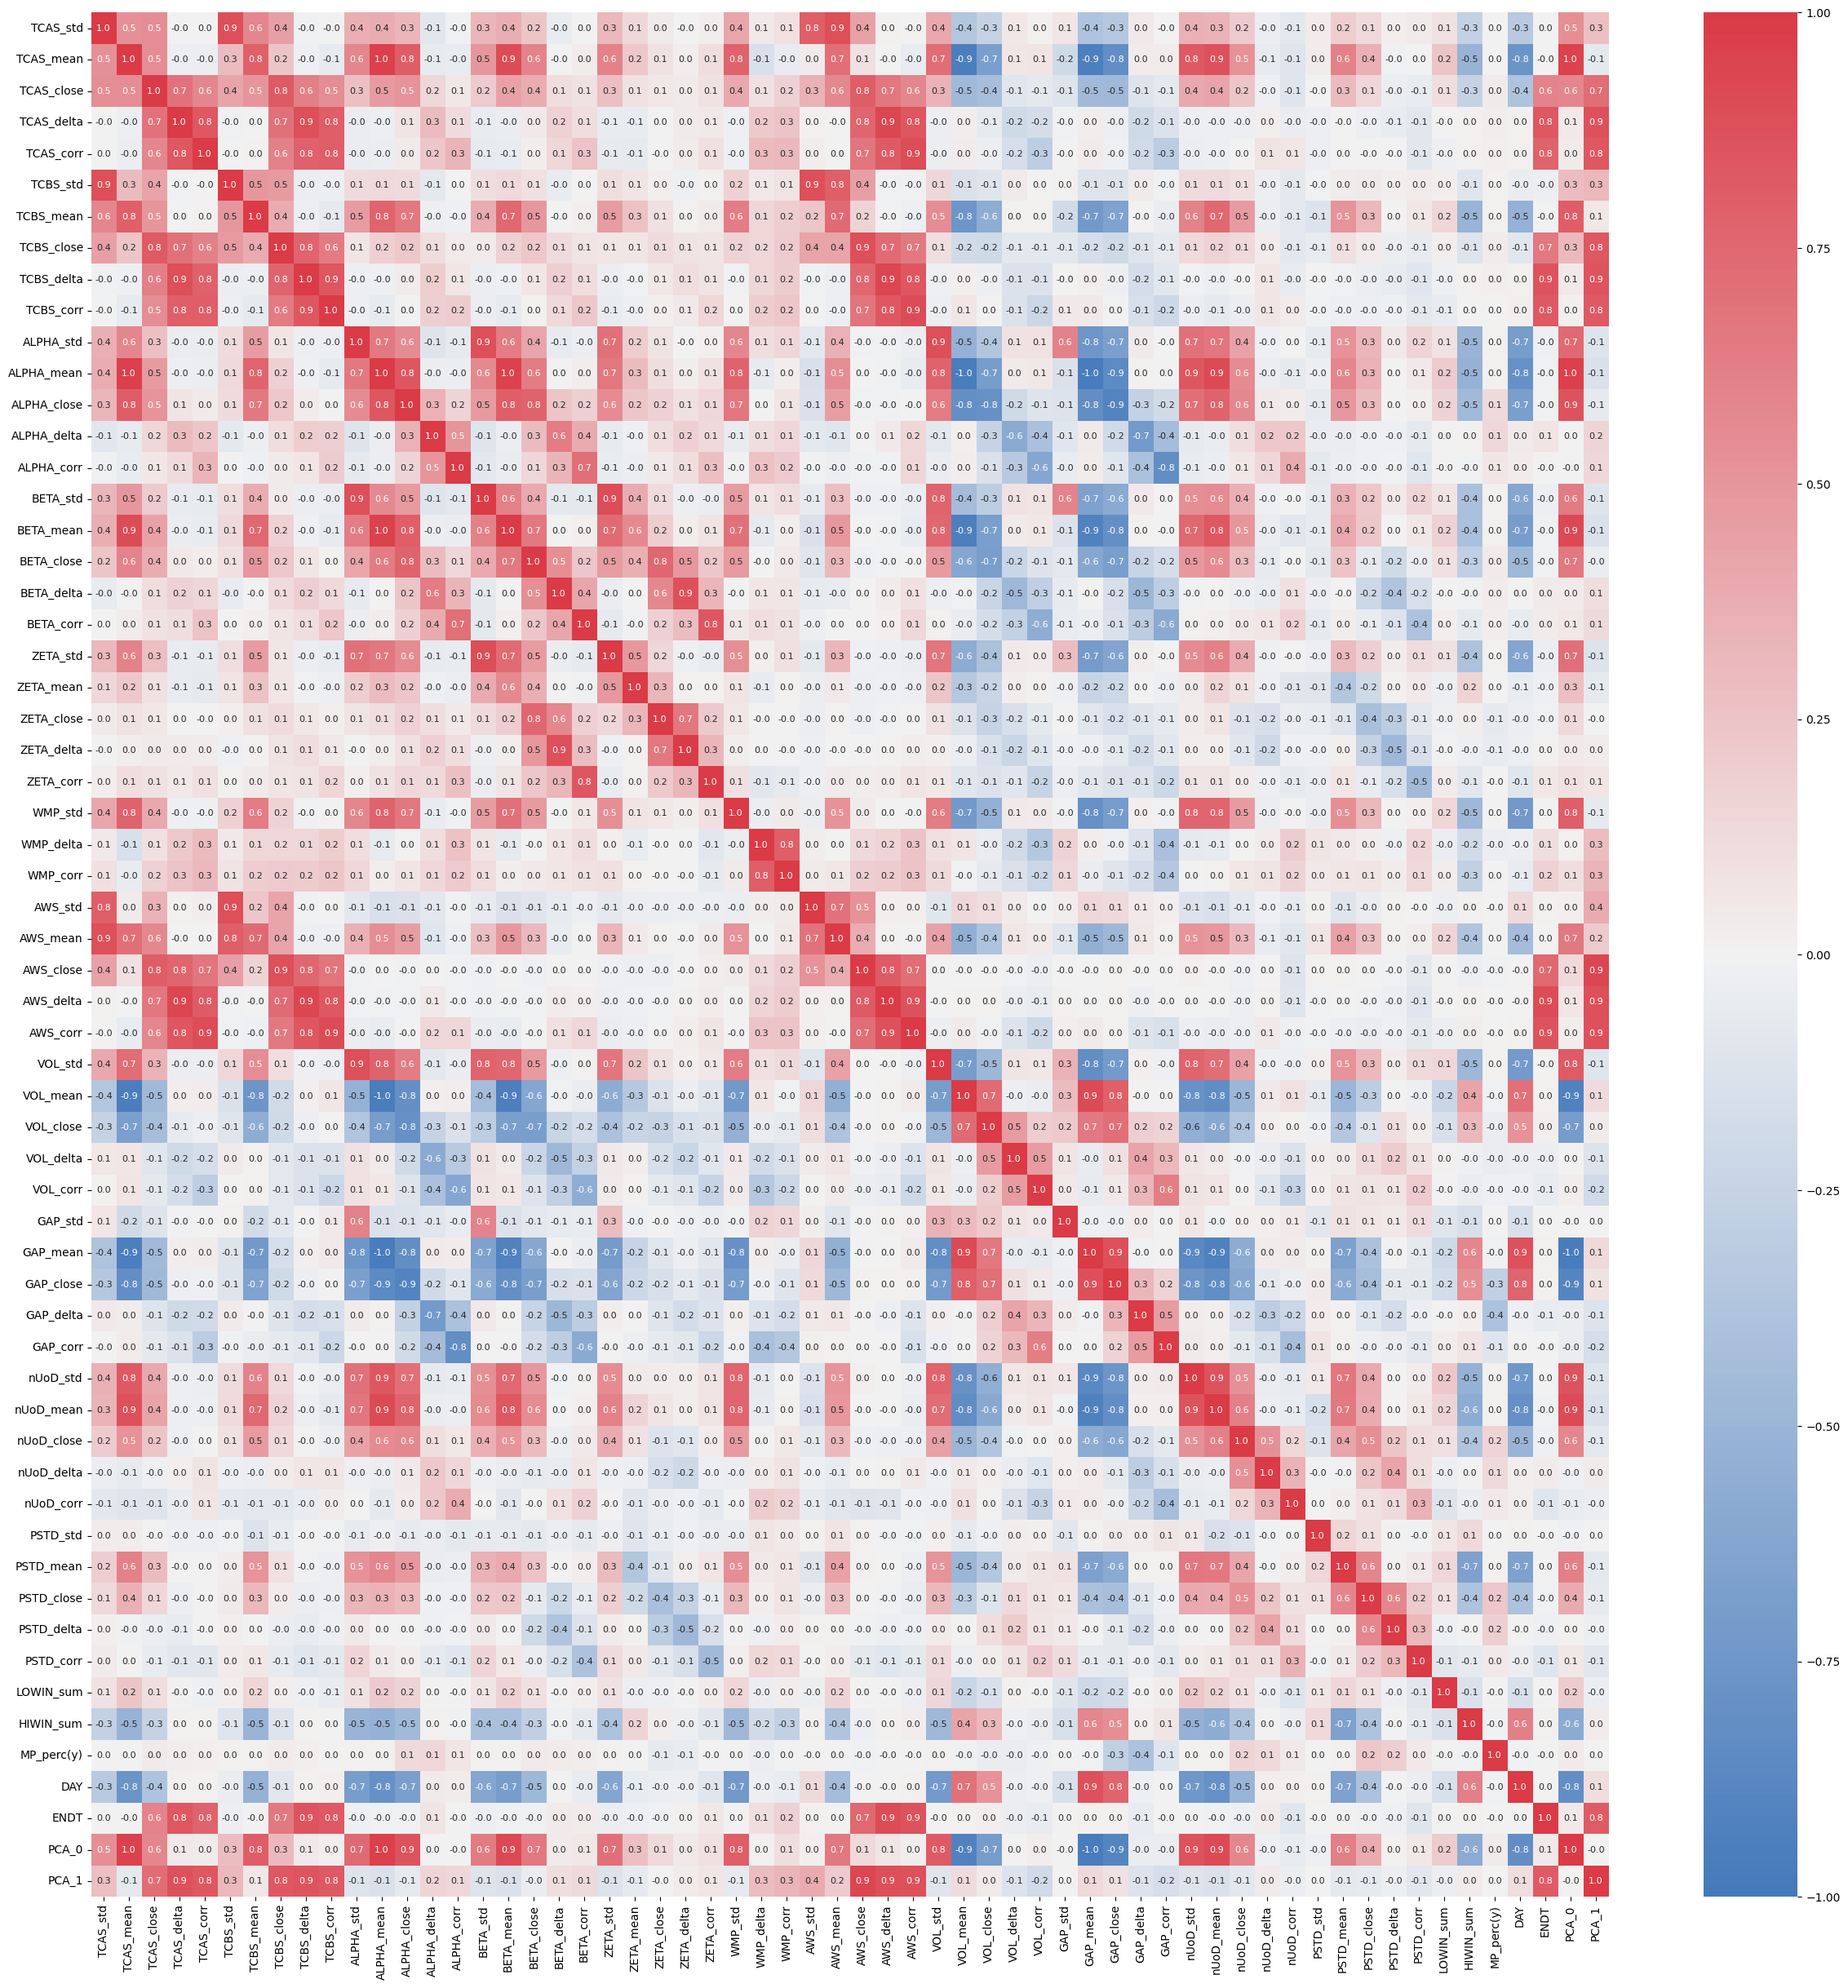

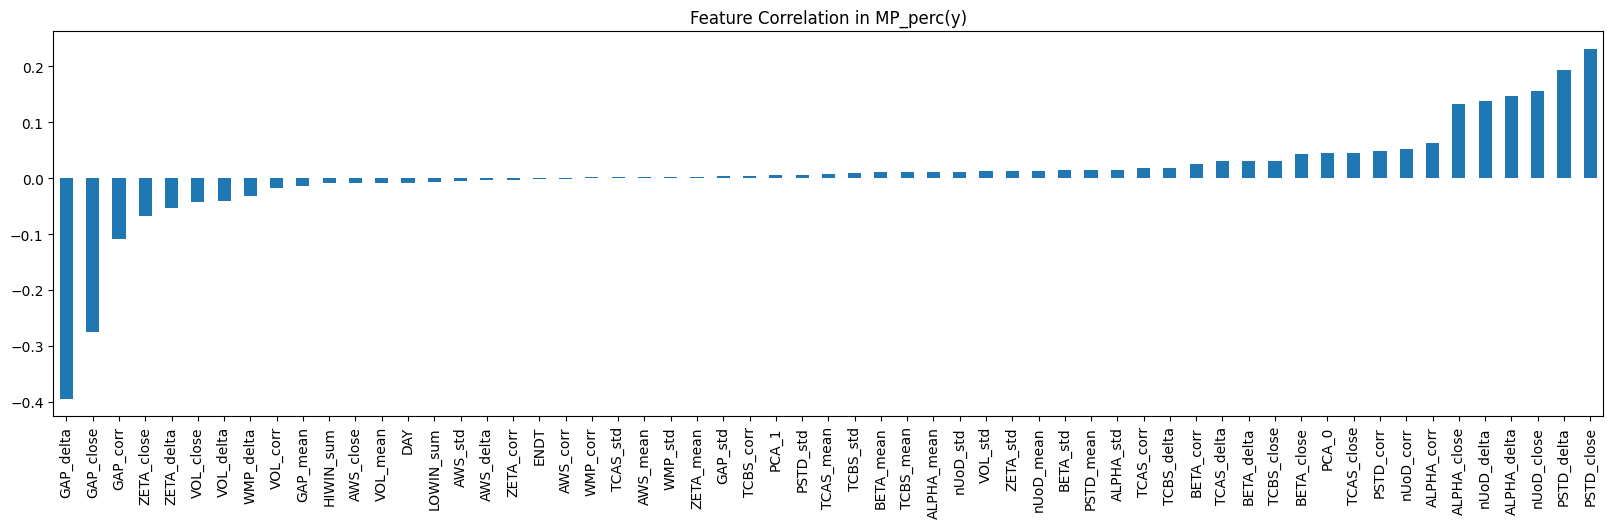

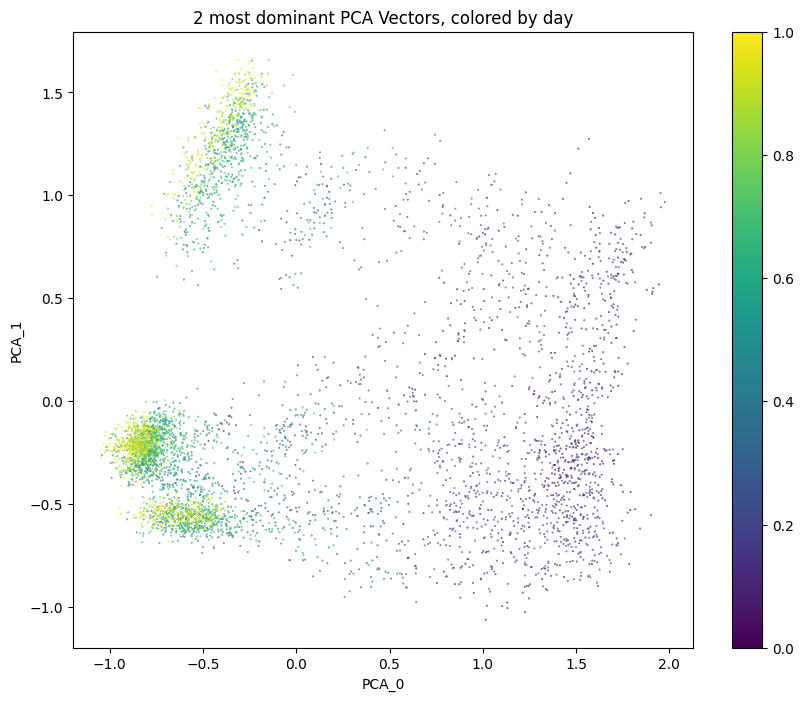

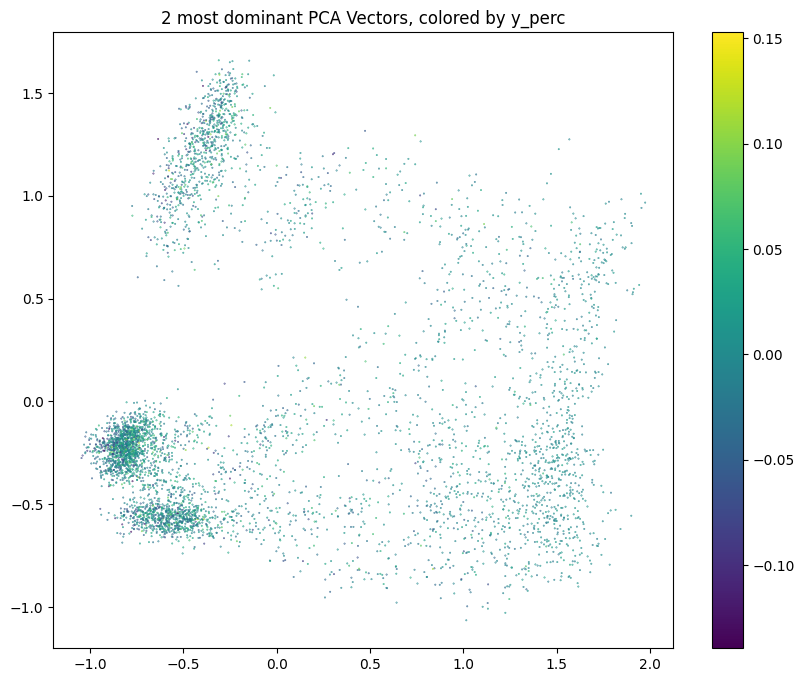

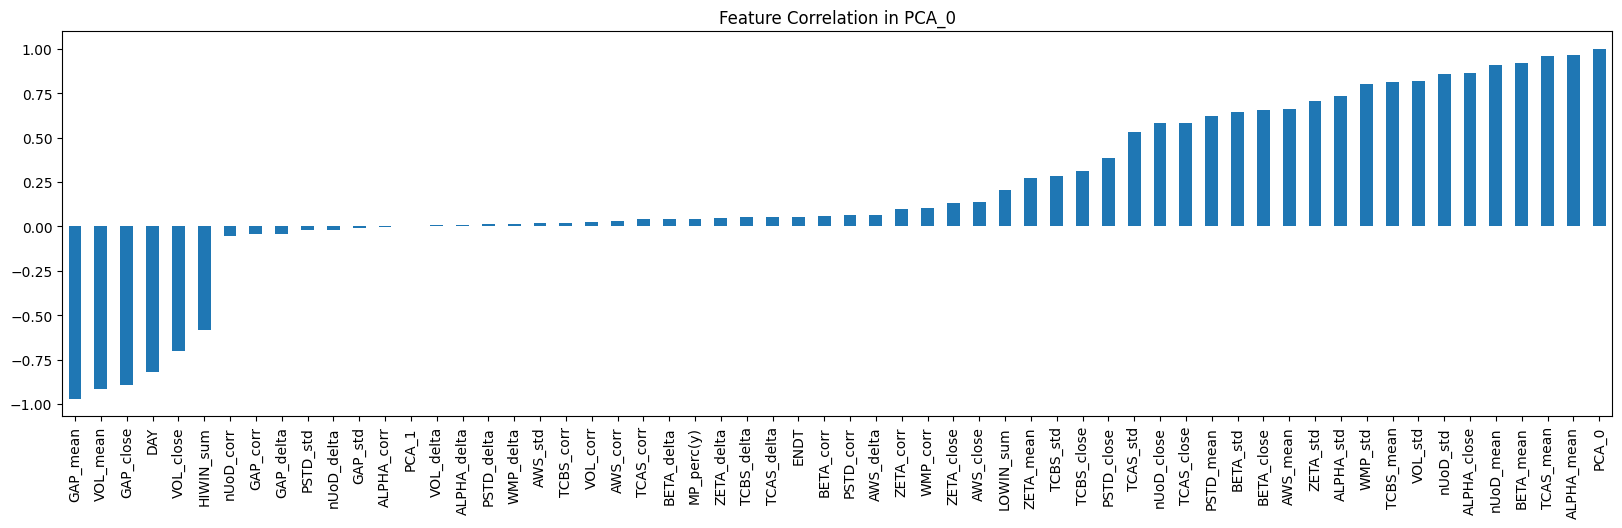

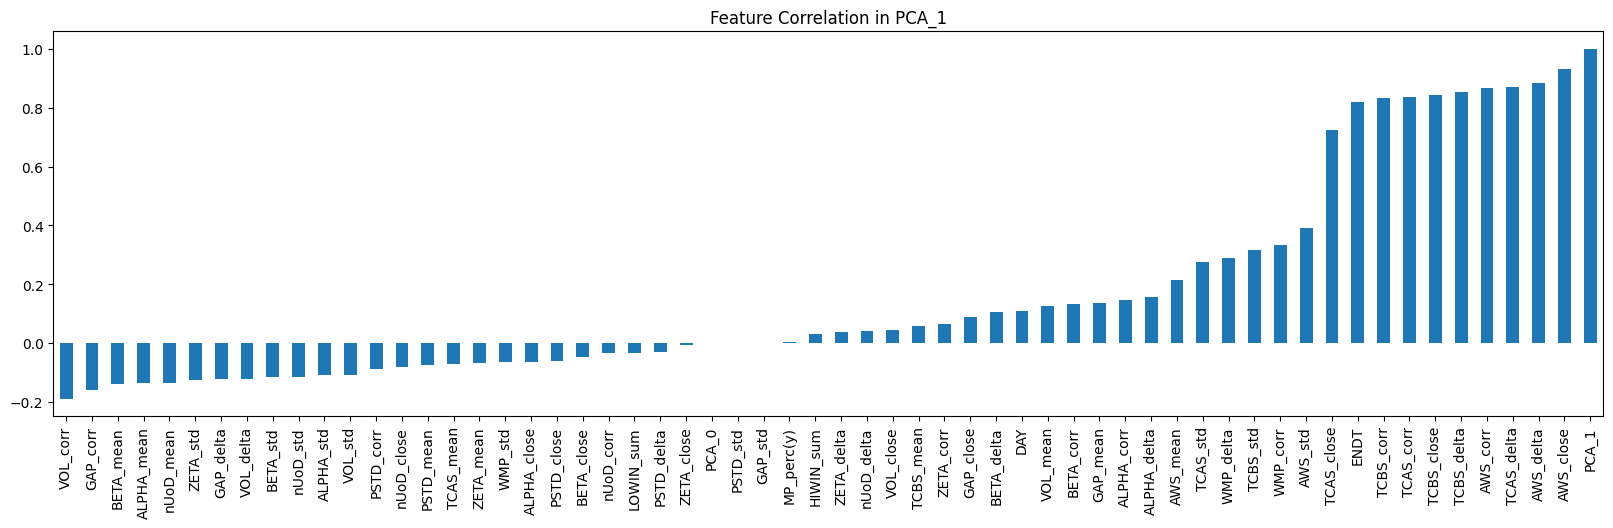

In [22]:
X = pca_vectors[:,:2]
import seaborn as sns

for i in range(X.shape[1]):
    data[f"PCA_{i}"] = X[:,i]

plt.figure(figsize=(30,30))
corr_map = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_map, vmin=-1, vmax=1, cmap=cmap, center=0, annot=True, fmt=".1f", annot_kws={"size": 8})
plt.show()

corr_map[corr_map.index != "MP_perc(y)"]["MP_perc(y)"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in MP_perc(y)")
plt.show()

plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by day")
plt.scatter(X[:,0], X[:,1], c = data["DAY"].to_numpy(), s = 1/2**3)
plt.xlabel("PCA_0")
plt.ylabel("PCA_1")
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_perc")
plt.scatter(X[:,0], X[:,1], c = data["MP_perc(y)"], s = 1/2**3)
plt.colorbar()
plt.show()

corr_map["PCA_0"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_0")
plt.show()
corr_map["PCA_1"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_1")
plt.show()

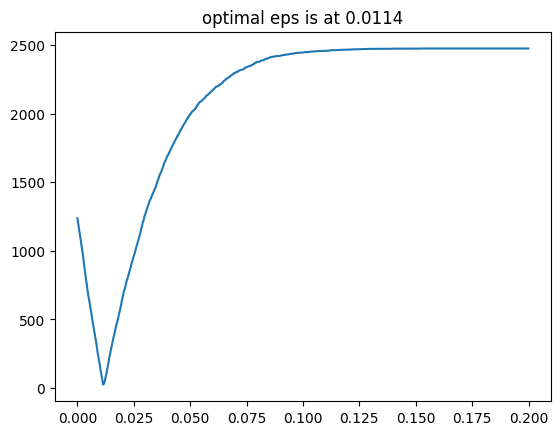

In [23]:
y_perc = data["MP_perc(y)"]

eps_vals = np.arange(0, 0.2, 0.0001)

def eps_y_bool(arr, eps):
    return np.std([np.sum(arr > eps),np.sum(arr < -eps), np.sum( (arr < eps) & (arr > -eps) )])
    
split_ratios = []
for eps in eps_vals:
    split_ratios.append(eps_y_bool(y_perc, eps))

optimal_eps = eps_vals[np.argmin(split_ratios)]
plt.title(f"optimal eps is at {optimal_eps}")
plt.plot(eps_vals, split_ratios)
plt.show()

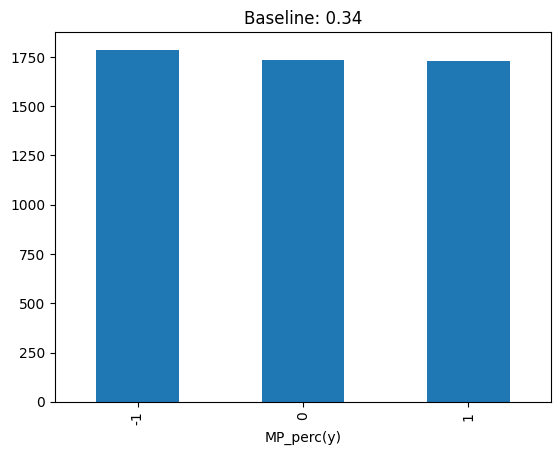

In [24]:
def gen_y_bool(y):
    if abs(y) < optimal_eps:
        return 0
    elif y > 0:
        return 1
    else:
        return -1
    
y_bool = y_perc.apply(gen_y_bool)
y_bool_splits = y_bool.value_counts()
y_bool_splits.plot(kind = "bar")
baseline = np.max(y_bool_splits) / len(data)
plt.title(f"Baseline: {baseline:.2f}")
plt.show()

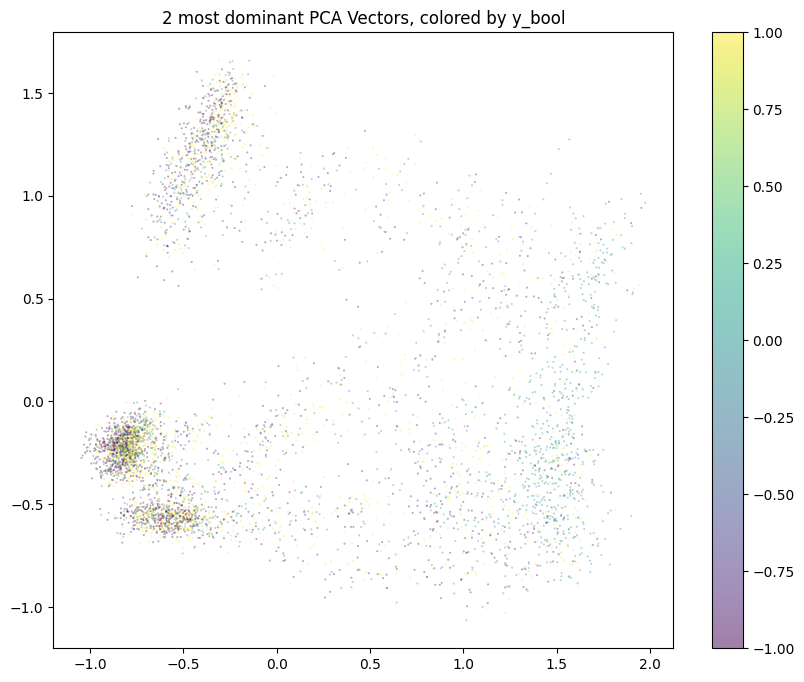

In [25]:
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_bool")
plt.scatter(X[:,0], X[:,1], c = y_bool.to_numpy(), s = 1/2**3, alpha=0.5)
plt.colorbar()
plt.show()

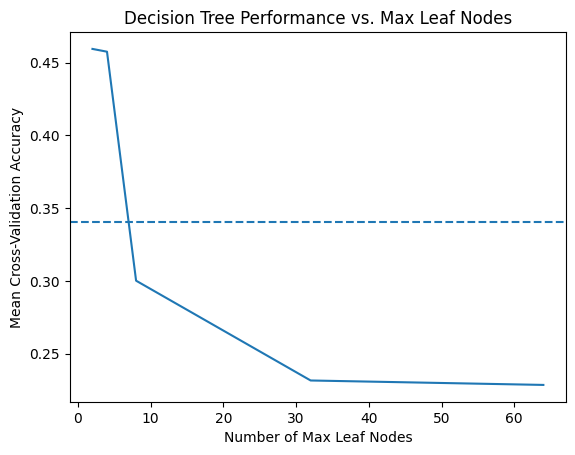

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


cv_scores = []
tree_nodes = [2,4,8,16,32,64]

mask = y_bool != 0

for n in tree_nodes:
    clf = DecisionTreeClassifier(max_leaf_nodes=n)
    scores = cross_val_score(clf, data[x_features], y_bool, cv=5)  # Assuming you have data X and labels y
    cv_scores.append(scores.mean())

plt.plot(tree_nodes, cv_scores)
plt.xlabel('Number of Max Leaf Nodes')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Decision Tree Performance vs. Max Leaf Nodes')
plt.axhline(baseline, linestyle = "--")
plt.show()

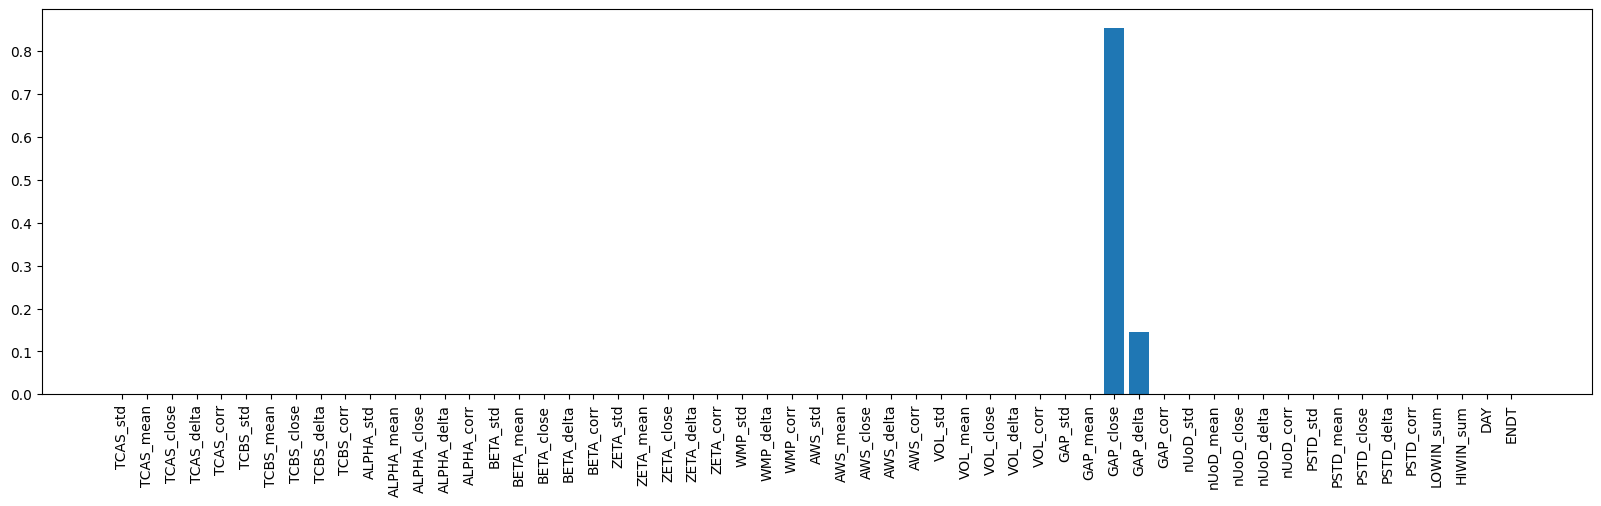

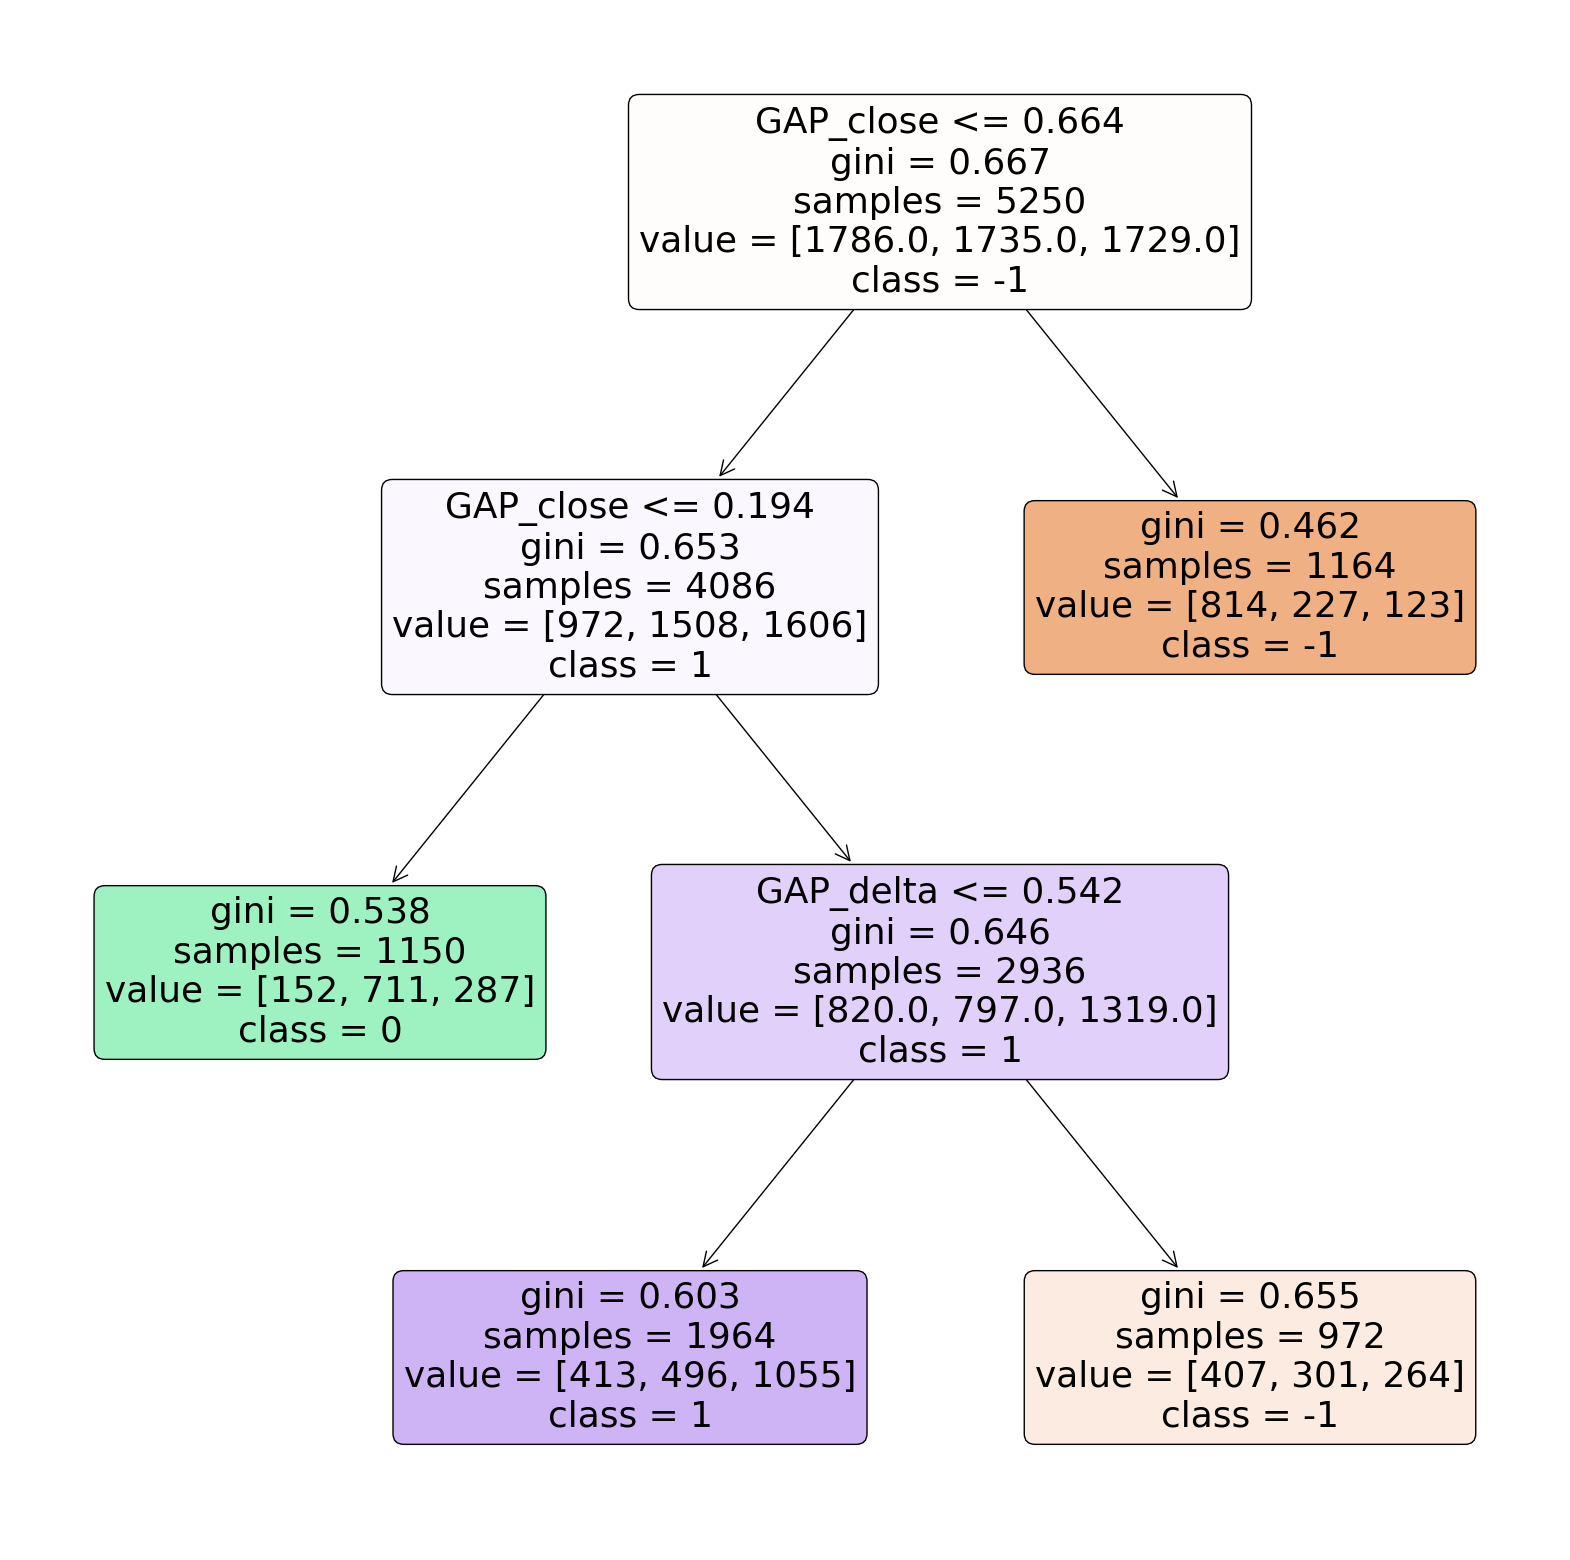

In [35]:
clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(data[x_features],y_bool)

plt.figure(figsize=(20,5))
plt.bar(x_features, clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=x_features, class_names=[str(a) for a in clf.classes_], filled=True, rounded=True)
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix

ypred = clf.predict(data[x_features])
ytrue = y_bool.to_numpy()
conf_matrix = confusion_matrix(ytrue, ypred, labels=clf.classes_)

for i, clas in enumerate(clf.classes_):
    print(f"Class {clas} Analysis...")
    
    print("Baseline =", np.mean(ytrue == clas))
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN
    
    print("TP =", TP)
    print("FP =", FP)
    print("TN =", TN)
    print("FN =", FN)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)
    print()


Class -1 Analysis...
Baseline = 0.3401904761904762
TP = 1221
FP = 915
TN = 2549
FN = 565
Precision = 0.5716292134831461
Recall = 0.6836506159014558
F1 Score = 0.6226415094339623

Class 0 Analysis...
Baseline = 0.3304761904761905
TP = 711
FP = 439
TN = 3076
FN = 1024
Precision = 0.6182608695652174
Recall = 0.4097982708933718
F1 Score = 0.4928942807625649

Class 1 Analysis...
Baseline = 0.3293333333333333
TP = 1055
FP = 909
TN = 2612
FN = 674
Precision = 0.5371690427698574
Recall = 0.6101792943898207
F1 Score = 0.5713512049823992



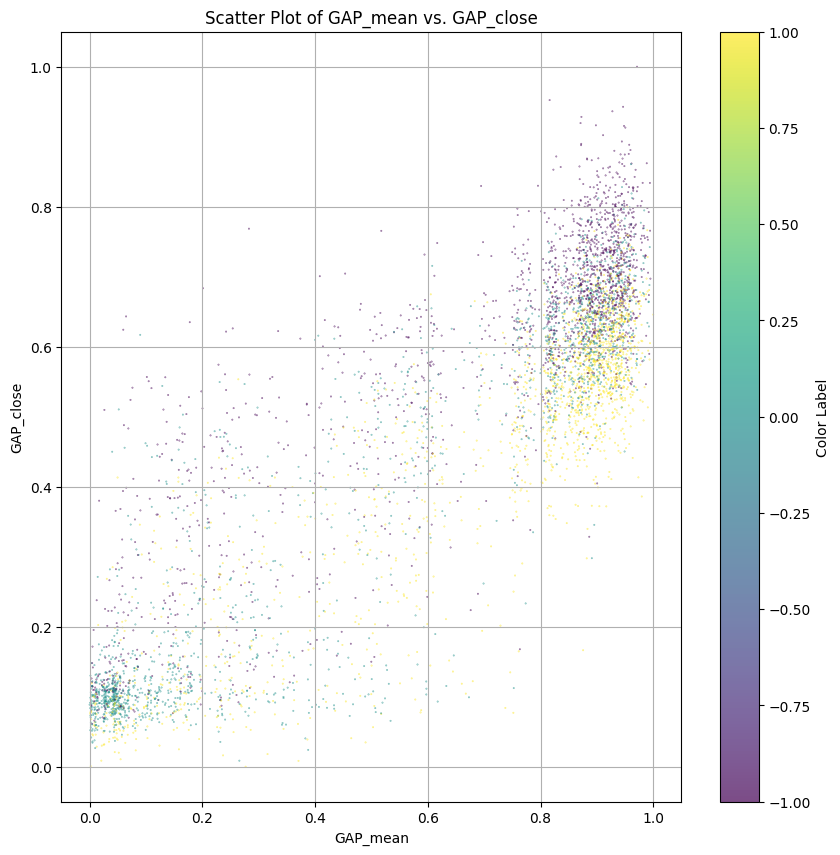

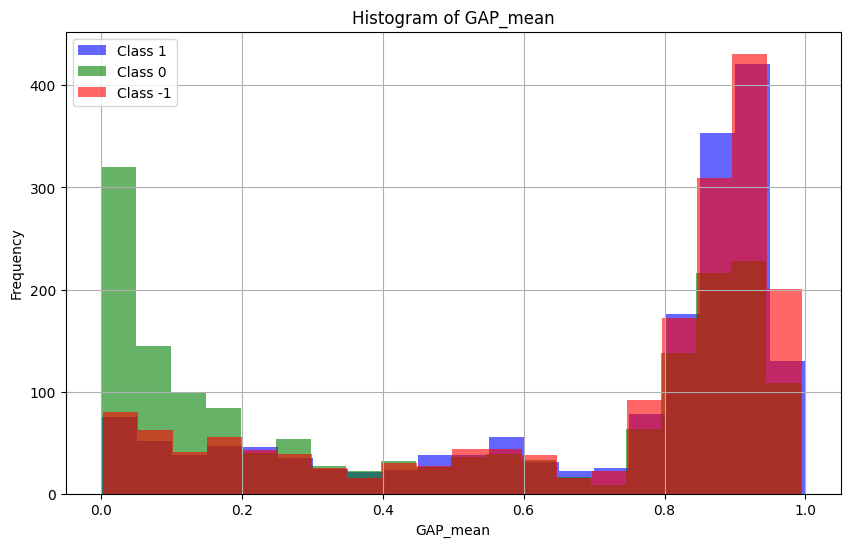

In [32]:
x_feat = "GAP_mean" # most important features
y_feat = "GAP_close" # 2nd most important / interesting feature

plt.figure(figsize=(10, 10))
plt.scatter(data[x_feat], data[y_feat], s=1/2**3, c=y_bool, alpha=0.7, marker='o')
plt.colorbar(label='Color Label')
plt.xlabel(x_feat)
plt.ylabel(y_feat)
plt.title(f'Scatter Plot of {x_feat} vs. {y_feat}')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data[y_bool == 1][x_feat], bins=20, alpha=0.6, label="Class 1", color='blue')
plt.hist(data[y_bool == 0][x_feat], bins=20, alpha=0.6, label="Class 0", color='green')
plt.hist(data[y_bool == -1][x_feat], bins=20, alpha=0.6, label="Class -1", color='red')
plt.legend()
plt.xlabel(x_feat)
plt.ylabel('Frequency')
plt.title(f'Histogram of {x_feat}')
plt.grid(True)
plt.show()